# Modelling of a power electricity mixsupporting the demand in France in 2050

by Elisa Escanez and Sébastien Castets

tutored by Aude Rondepierre and Charles Dossal

## Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import csv
import time
import sys
# Imports pour pyomo
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

import panel as pn 
from ipywidgets import interactive, interact_manual
import ipywidgets as widgets

#%matplotlib inline
pn.extension()


from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas

from modeles import modele
from modeles_complet import modele_complet

## Utils

In [2]:
col = {"offshore" : '#1f4e79', "onshore" : '#548235' , "pv" : "#ffc000", "phs" : "#bdd7ee", "battery" : "#7030a0", "biogas" :"#843c0c", "methanation": "#7f6000", "gas": "grey", "lake": "#4169E1", "river" : "#09F1D3"}
tec = ["offshore","onshore","pv","river","lake","biogas","phs","battery","methanation"]
stor = ["phs","battery","methanation"]

In [13]:
# Dashboard

def show(week,name):
    
    if name == "scen2006": 
        d = scen2006
        Volume = Volume_str_opti 
    else :
        d = pd.read_csv(name+"/"+name+"_hourly_generation.csv", index_col = 0, squeeze = True)
        Volume = pd.read_csv(name+"/"+name+"_Volume.csv", index_col = 0, squeeze = True)
        
    tec_aux = tec
    if not("river" in d.columns): tec_aux = list(set(tec_aux) - set(["river"]))
    if not("lake" in d.columns): tec_aux = list(set(tec_aux) - set(["lake"]))
    
    h  = 168*(week-1)+np.arange(1,169)
    ymin, ymax = -45,130
    h_ratio = np.ones(len(stor)+1)
    h_ratio[0] = 2 # 1er subplot 2 fois plus grand
    fig, axs = plt.subplots(len(stor)+1, figsize = (15,15),gridspec_kw={'height_ratios':h_ratio})
    
    # Stockage 
    sum_s = 0
    for i in stor: 
        sum_s += d["Storage " + i][h]
    for s in stor[::-1]:
        aux = "Storage " + s
        axs[0].fill_between(h, sum_s, color = col[s], label = aux)
        sum_s -= d[aux][h]

    # Production
    sum_g = 0
    for i in tec_aux: 
        sum_g += d[i][h]
    for gene in tec_aux[::-1]: 
        axs[0].fill_between(h,sum_g, color = col[gene], label = gene )
        sum_g -= d[gene][h]
    
    # Demande
    axs[0].plot(h, d["Electricity demand"][h], color = 'r' , label = "Demand",linewidth= 4)

    axs[0].vlines(x=np.linspace(h[0],h[-1],8),ymin = ymin, ymax = ymax,colors="black",linestyle='dotted',linewidth=2)
    axs[0].set_ylabel("Production (GWh)")
    axs[0].set_ylim(ymin,ymax)
    axs[0].legend(loc ="upper right")
    axs[0].set_title("Semaine "+ str(week))
        
    for s in range(0,len(stor)):
        axs[s+1].fill_between(h, d["Stored " + stor[s]][h], color = col[stor[s]])
        axs[s+1].hlines(y=Volume[s], xmin = h[0], xmax = h[-1], label = "limit", color = 'red')
        axs[s+1].set_title("Stored " + str(stor[s]))
        axs[s+1].vlines(x=np.linspace(h[0],h[-1],8),ymin = 0, ymax = Volume[s]+10,colors="black",linestyle='dotted',linewidth=2)
        
        
def affichage(simu):
    print(" --- Q ---")
    for i in simu.model.Q:
        print(i," : ",pyo.value(simu.model.Q[i]))   
    print(" --- S ---")   
    for i in simu.model.S:
        print(i," : ",pyo.value(simu.model.S[i]))
    print(" --- volume ---")
    for i in simu.model.volume:
        print(i," : ",pyo.value(simu.model.volume[i]))
    print(" --- cost --- ")
    print(simu.cost())

# 1. Anlyze of outputs from P. Quirion

In [3]:
scenarios = pd.read_csv("outputs/scenarios.csv", index_col="scen")
cost_decomposition = pd.read_csv("outputs/cost decomposition for all scenarios.csv", index_col="scen")

In [4]:
scen = 157 #choosen scenario 
list(scenarios.iloc[scen][5:])

['central', 'central', 'central', 'central', 'central']

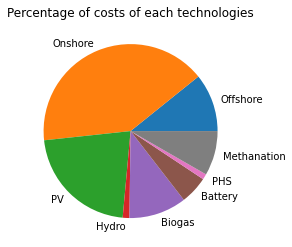

In [5]:
plt.figure()
plt.pie(list(map(lambda x: float(x[:-1]),list(cost_decomposition.iloc[scen]))), labels = ["Offshore","Onshore","PV","Hydro","Biogas","Battery","PHS","Methanation"])
plt.title("Percentage of costs of each technologies")
plt.show()

In [11]:
#Optimization results
scen2006 = pd.read_csv("outputs/real CF after internalization of LC/2006_LC_internalized.csv", index_col = "hour")
scen2006.columns = ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'gas', 'phs',
       'battery', 'methanation', 'Electricity demand', 'Storage phs', 'Storage battery', 'Storage methanation', 'Stored battery',
       'Stored phs', 'Stored methanation', 'elec_price', 'gas_price']
scen2006.head()

,offshore,onshore,pv,river,lake,biogas,gas,phs,battery,methanation,Electricity demand,Storage phs,Storage battery,Storage methanation,Stored battery,Stored phs,Stored methanation,elec_price,gas_price
hour,,,,,,,,,,,,,,,,,,,
0,10.93,40.80,0.0,1.27,0.0,0.0,0.0,0.00,0.0,0.0,28.69,-9.30,-7.35,-7.66,31.75,82.95,1813.37,0.0,0.0
1,0.00,42.09,0.0,1.30,0.0,0.0,0.0,0.00,0.0,0.0,31.21,-4.52,0.00,-7.66,38.37,91.78,1817.90,0.0,0.0
2,11.12,31.67,0.0,0.00,0.0,0.0,0.0,1.87,0.0,0.0,27.70,-9.30,0.00,-7.66,38.37,96.08,1822.42,0.0,0.0
3,0.00,43.18,0.0,1.12,0.0,0.0,0.0,0.00,0.0,0.0,27.99,-8.65,0.00,-7.66,38.37,102.84,1826.94,0.0,0.0
4,2.17,42.95,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,28.16,-9.30,0.00,-7.66,38.37,111.06,1831.46,0.0,0.0


In [12]:
# Optimal values found
Volume_str_opti = pd.Series([180 ,74.14, 12499.09], index = stor)
S_opti = pd.Series([9.3,20.08, 7.66], index = stor)
Q_tec_opti = pd.Series([12.64, 79.73, 121.98, 7.5, 13 ,32.93, 9.3, 20.08, 32.93], index = tec)
Cost_opti = 21.84 

# 2. Simulation of the EOLES model
## 2.1. Choice of Q, S and VOLUME

In [14]:
phs_bounds = {"Q_lower":5.2,"Q_upper": 9.3, "S_lower":4.2, "S_upper":9.3, "Volume_lower":80.16, "Volume_upper":180}
vre_upper_bounds = {"onshore":120, "offshore": 20, "pv": 218}

In [15]:
V = widgets.Text(value='Volume de stockage (GWh)', disabled=True)
Volume_phs = widgets.FloatSlider(min=phs_bounds["Volume_lower"], max=phs_bounds["Volume_upper"], step=0.01, description='Volume phs',value = Volume_str_opti["phs"])
Volume_methanation = widgets.FloatSlider(min=0, max=Volume_str_opti["methanation"]*5, step=0.01, description='Volume methanation',value = Volume_str_opti["methanation"])
Volume_battery =  widgets.FloatSlider(min=0, max=Volume_str_opti["battery"]*5, step=0.01, description='Volume battery',value = Volume_str_opti["battery"])  

Q = widgets.Text(value='Capcité installée (GW)', disabled=True)
Q_offshore= widgets.FloatSlider(min=0, max=vre_upper_bounds["offshore"], step=0.01, description='Q offshore',value = Q_tec_opti["offshore"])
Q_onshore= widgets.FloatSlider(min=0, max=vre_upper_bounds["onshore"], step=0.01, description='Q onshore',value = Q_tec_opti["onshore"])
Q_pv= widgets.FloatSlider(min=0, max=vre_upper_bounds["pv"], step=0.1, description='Q pv',value = Q_tec_opti["pv"])
Q_river= widgets.FloatSlider(min=0, max=Q_tec_opti["river"], step=0.01, description='Q river',value = Q_tec_opti["river"])
Q_lake= widgets.FloatSlider(min=12.855, max=13, step=0.01, description='Q lake',value = Q_tec_opti["lake"])
Q_biogas= widgets.FloatSlider(min=0, max=Q_tec_opti["biogas"]*5, step=0.01, description='Q biogas',value = Q_tec_opti["biogas"])
Q_phs= widgets.FloatSlider(min=phs_bounds["Q_lower"], max=phs_bounds["Q_upper"], step=0.01, description='Q phs',value = Q_tec_opti["phs"])
Q_battery= widgets.FloatSlider(min=0, max=Q_tec_opti["battery"]*5, step=0.01, description='Q battery',value = Q_tec_opti["battery"])
Q_methanation= widgets.FloatSlider(min=0, max=Q_tec_opti["methanation"]*5, step=0.01, description='Q methanation',value = Q_tec_opti["methanation"])

S = widgets.Text(value='Capacité de charge (GW)', disabled=True)
S_phs= widgets.FloatSlider(min=phs_bounds["S_lower"], max=phs_bounds["S_upper"], step=0.01, description='S phs',value = S_opti["phs"])
S_methanation = widgets.FloatSlider(min=0, max=S_opti["methanation"]*5, step=0.01, description='S methanation',value = S_opti["methanation"])
warn = widgets.Textarea(value='      Attention ! \n      Volume > Q  et  Volume > S', disabled=True)

widgets.HBox([widgets.VBox([Q, Q_offshore, Q_onshore, Q_pv, Q_river, Q_lake,Q_biogas ,Q_phs,Q_battery,Q_methanation]),
widgets.VBox([V,Volume_phs,Volume_battery,Volume_methanation, warn]), widgets.VBox([S,S_methanation, S_phs])])


In [16]:
Q_tec = [Q_offshore.value, Q_onshore.value, Q_pv.value, Q_river.value, Q_lake.value,Q_biogas.value ,Q_phs.value,Q_battery.value,Q_methanation.value]
Volume_str = [Volume_phs.value,Volume_battery.value,Volume_methanation.value]
S =  [Q_phs.value,Q_battery.value,S_methanation.value]


# Capacity in GW Q
Q_tec = pd.Series( Q_tec, index = tec)

    
# Energy volume of storage technology in GWh VOLUME
Volume_str =pd.Series(Volume_str, index = stor)

#Storage charging power S
S =pd.Series(S, index = stor)


print("Fixed values : ")
print("--------- Q ---------")
print(Q_tec)
print("-------- VOLUME -------")
print(Volume_str)
print("--------- S ---------")
print(S)

Fixed values : 
--------- Q ---------
offshore        12.64
onshore         79.73
pv             121.98
river            7.50
lake            13.00
biogas          32.93
phs              9.30
battery         20.08
methanation     32.93
dtype: float64
-------- VOLUME -------
phs              180.00
battery           74.14
methanation    12499.09
dtype: float64
--------- S ---------
phs             9.30
battery        20.08
methanation     7.66
dtype: float64


## 2.2 Run the simulation

In [ ]:
#Run the simulation
simu = modele(Q_tec, Volume_str, S)
simu.load_param("inputs/")
simu.run()

In [ ]:
#Write results
res = simu.write_results('simu')

## 2.3 Analyze of the results

In [ ]:
noms_simu = ["scen2006", "simu_opti", 'simu_scen2', 'simu_scen3', 'simu_scen4']
# Dashboard
interactive_plot = interact_manual(show, week=widgets.IntText(value = 1), name = noms_simu)
interactive_plot

In [ ]:
cost_tecs = {}
col = {"offshore" : '#1f4e79', "onshore" : '#548235' , "pv" : "#ffc000", "phs" : "#bdd7ee", "battery" : "#7030a0", "biogas" :"#843c0c", "methanation": "#7f6000",  "lake": "#4169E1", "river" : "#09F1D3"}
for t in ['offshore','onshore','pv','phs', 'battery','biogas','methanation','lake','river']:
          cost_tecs[t] = pyo.value(simu.cost_by_tec(t))
        
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(aspect="equal"))
data = cost_tecs.values()
recipe = [i + " : "+str(round(cost_tecs[i], 2) )for i in ['offshore','onshore','pv','phs', 'battery','biogas','methanation','lake','river'] ]


wedges, texts = ax.pie(data, startangle=30, colors = col.values())

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1 
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)


plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([19.801,20.059,20.409,22.608,20.180], 'o')
plt.xticks(np.arange(5), labels = ["scen 1", "scen 2", "scen 3", "scen 4", "scen 5"])
plt.grid()
plt.ylabel("Cost (b€)")
plt.xlabel("Scenario")
plt.show()

# 3. Optimization
## 3.1 Scenarios building

In [ ]:
vre_profile = pd.read_csv("inputs/vre_profiles2006.csv", index_col=[0, 1], squeeze=True, header=None)
vre_profile.head()

In [ ]:
#scenario 2
sem1 = 28
sem2 = 48

vre_profile2 = vre_profile
vre_profile2["pv"][sem1*nb_h: (sem1+1)*nb_h] =  vre_profile2["pv"][sem2*nb_h: (sem2+1)*nb_h] 

In [ ]:
#scenario 3
vre_profile3 = vre_profile2
vre_profile3["pv"][29*nb_h: (29+1)*nb_h] =  vre_profile3["pv"][sem2*nb_h: (sem2+1)*nb_h] 
vre_profile3["pv"][30*nb_h: (30+1)*nb_h] =  vre_profile3["pv"][sem2*nb_h: (sem2+1)*nb_h] 
vre_profile3["pv"][31*nb_h: (31+1)*nb_h] =  vre_profile3["pv"][sem2*nb_h: (sem2+1)*nb_h] 

In [ ]:
#scenario 4
nb_h = 24*7
sem = 45
plt.figure(figsize = (30,5))
plt.plot(vre_profile["onshore"])
plt.xlim(sem*nb_h,(sem+1)*nb_h)

In [ ]:
#scenario 5
river_profile = pd.read_csv("inputs/run_of_river.csv", header = None , index_col = 0, squeeze = True)
river_profile[23*nb_h:36*nb_h] = 0
river_profile.to_csv("river_profile_scen5.csv", header = False)

## 3.2. Run the optimization

In [ ]:
simu1 = modele_complet()
simu1.load_param("inputs/")
simu1.run()
affichage(simu1)

In [ ]:
simu2 = modele_complet()
simu2.load_param("inputs/", name_load_factor = "vre_profile_scen2.csv")
simu2.run()
affichage(simu2)